In [1]:
import warnings
import os
import json
import sys

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# from trips_count_predictor.city_loader.city_loader import CityLoader

warnings.simplefilter(action='ignore')



In [2]:
import os
root = '/Users/mc/Desktop/IEEE_ACM_DS_RT_2020/'
data_path = os.path.join(root, 'Data', 'Louisville')
trips = pd.DataFrame()
for file in os.listdir(data_path):
    if 'DocklessTripOpenData' in file:
        trips = trips.append(pd.read_csv(os.path.join(data_path, file)))
trips.shape

(505993, 13)

In [3]:
trips.columns

Index(['TripID', 'StartDate', 'StartTime', 'EndDate', 'EndTime',
       'TripDuration', 'TripDistance', 'StartLatitude', 'StartLongitude',
       'EndLatitude', 'EndLongitude', 'DayOfWeek', 'HourNum'],
      dtype='object')

In [4]:
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon

(505911, 14)
(505911, 14)


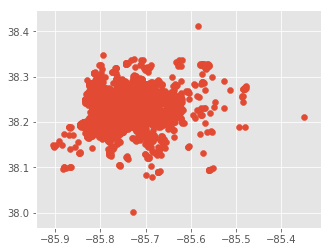

In [7]:
trips = trips[(trips.StartLongitude <-85) & (trips.EndLongitude <-85)]
trips = trips[(trips.StartLongitude >-90) & (trips.StartLongitude >-90)]
trips = trips[(trips.StartLatitude <39) & (trips.EndLongitude <39)]
trips = trips[(trips.StartLatitude >37) & (trips.StartLatitude >37)]


trips_o = trips.copy()
trips_d = trips.copy()
trips_o["geometry"] = trips.loc[:, ["StartLongitude", "StartLatitude"]].astype(float).apply(
    lambda x: Point(x["StartLongitude"], x["StartLatitude"]), axis=1
)
trips_d["geometry"] = trips.loc[:, ["EndLongitude", "EndLatitude"]].astype(float).apply(
    lambda x: Point(x["EndLongitude"], x["EndLatitude"]), axis=1
)
trips_o = gpd.GeoDataFrame(trips_o)
trips_d = gpd.GeoDataFrame(trips_d)
trips_o.crs = {"init": "epsg:4326"}
trips_d.crs = {"init": "epsg:4326"}
print(trips_d.shape)
print(trips_o.shape)
trips_o.plot()

rows= 116
cols= 124
end


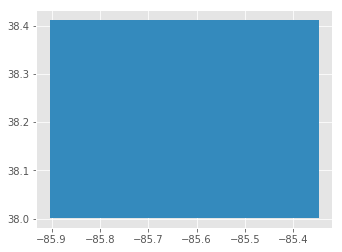

In [8]:
def get_city_grid (locations, bin_side_length):

    x_min, y_min, x_max, y_max = locations.total_bounds
    width = bin_side_length
    height = bin_side_length
    rows = int(np.ceil((y_max-y_min) / height))
    cols = int(np.ceil((x_max-x_min) / width))
    print('rows=', rows)
    print('cols=', cols)
    x_left = x_min
    x_right = x_min + width
    polygons = []
    for i in range(cols):
        y_top = y_max
        y_bottom = y_max - height
        for j in range(rows):
            polygons.append(Polygon([(x_left, y_top),
                                     (x_right, y_top),
                                     (x_right, y_bottom),
                                     (x_left, y_bottom)]))
            y_top = y_top - height
            y_bottom = y_bottom - height
        x_left = x_left + width
        x_right = x_right + width
    grid = gpd.GeoDataFrame({"geometry":polygons})

    grid["zone_id"] = range(len(grid))
    grid.crs = {"init": "epsg:3857"}

    return grid.to_crs({"init": "epsg:4326"})

grid = get_city_grid(trips_o.to_crs({"init": "epsg:3857"}), 500)
print('end')
grid.plot()

In [9]:
trips_o = gpd.sjoin(
    trips_o,
    grid,
    how='left',
    op='within'
)

In [10]:
trips_o.HourNum = trips_o.HourNum.replace(24, 0)

In [11]:
trips_o.columns

Index(['TripID', 'StartDate', 'StartTime', 'EndDate', 'EndTime',
       'TripDuration', 'TripDistance', 'StartLatitude', 'StartLongitude',
       'EndLatitude', 'EndLongitude', 'DayOfWeek', 'HourNum', 'geometry',
       'index_right', 'zone_id'],
      dtype='object')

In [12]:
grid["o_count"] = trips_o.groupby("zone_id").TripID.count()

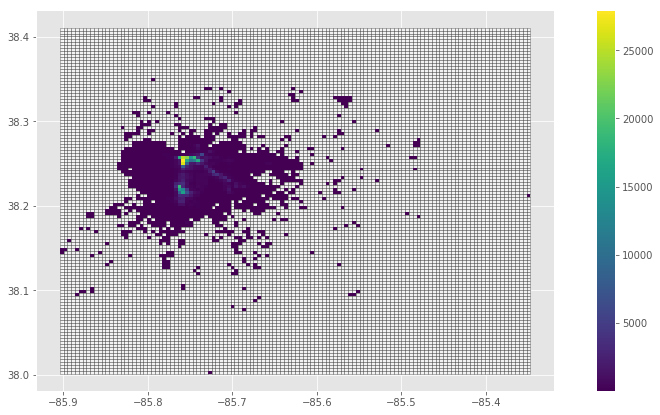

In [13]:
fig, ax = plt.subplots(figsize=(15, 7))
grid.plot(color='white', edgecolor="black", alpha=0.5, ax=ax)
grid.dropna().plot(column="o_count", ax=ax, legend=True)

In [14]:
trips_d = gpd.sjoin(
    trips_d,
    grid,
    how='left',
    op='within'
)

In [15]:
grid["d_count"] = trips_o.groupby("zone_id").TripID.count()

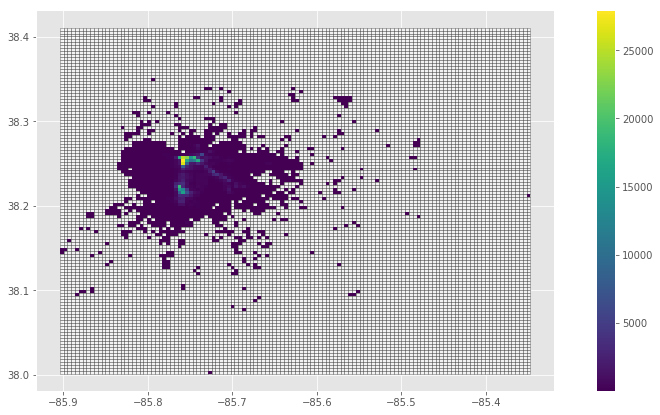

In [16]:
fig, ax = plt.subplots(figsize=(15, 7))
grid.plot(color='white', edgecolor="black", alpha=0.5, ax=ax)
grid.dropna().plot(column="o_count", ax=ax, legend=True)

In [17]:
grid["o_count_14"] = trips_o.loc[trips_o.HourNum.isin([14])].groupby("zone_id").TripID.count()

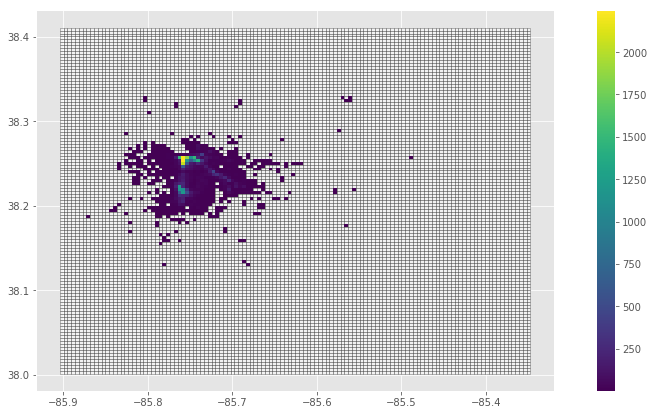

In [18]:
fig, ax = plt.subplots(figsize=(15, 7))
grid.plot(color='white', edgecolor="black", alpha=0.5, ax=ax)
grid.dropna().plot(column="o_count_14", ax=ax, legend=True)

In [19]:
grid.columns

Index(['geometry', 'zone_id', 'o_count', 'd_count', 'o_count_14'], dtype='object')